# Präsenzversuch zum Laval-Rotor

Name:  Noel Schwibus

Datum:  19.01.2024

Gruppe: 45

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:

Kann man die die kritischen Drehzahlen mit diesem Versuchsaufbau bestimmen?

## Erster Versuch: Prüfstand 3
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="figures/lavalrotor.jpg" width="500">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:

Der Versuchsaufbau besteht aus einer 0,75m lange Welle mit einem Durchmesser von 10mm. In der Mitte der Welle ist eine Scheibe befestigt. Die Scheibe hat ein Gewicht von 950g, einen Durchmesser von 99mm und ein Breite von 15mm. Die Welle ist in zwei Pendelkugellagern gelagert, welche sich an den Enden der Welle befinden. An einem der Lagerböcke befindet sich ein Beschleunigungssensor. In der Mitte befindet sich ein Fanglager, welches die maximale Auslenkung der Welle begrenzt. Die Welle ist durch eine Kupplung mit einem Elektromotor verbunden, welcher die Welle antreibt.

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240119_092536_lavalrotor_45_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240119_092536_lavalrotor_45_03.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
#print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

In [5]:
f = h5py.File(path_measurement_folder+"/"+filename,"r")

keys = list(range(20))
data = {}
for ii in keys:
    acc_x = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_x"])
    acc_y = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_y"])
    acc_z = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_z"])
    accel = [acc_x,acc_y,acc_z]
    
    timestamp = np.array(f[str(ii)]["RawData"][uuid_acceleration]["timestamp"])
    
    rpm = np.array(f[str(ii)]["RawData"][uuid_motor_rpm]["motor_rpm"])
    
    data.update({str(ii): {"acceleration" : accel, "rpm": rpm, "timestamp": timestamp}})


#print(data)

#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [6]:
importlib.reload(m_postprocessing)  # reload functions

for ii in keys:
    x_acc = data[str(ii)]["acceleration"][0]
    y_acc = data[str(ii)]["acceleration"][1]
    z_acc = data[str(ii)]["acceleration"][2]
    
    acc_vector = m_postprocessing.get_vec_accel(x_acc, y_acc, z_acc)
    data[str(ii)]["acceleration"] = acc_vector
    
    time = data[str(ii)]["timestamp"]
    data[str(ii)]["int_data"] = m_postprocessing.interpolation(time, acc_vector, interpolation_points)
#print(data)

for ii in keys:
    acc_int = data[str(ii)]["int_data"]
    time = data[str(ii)]["timestamp"]
    data[str(ii)]["amplitude"], data[str(ii)]["frequenz"] = m_postprocessing.my_fft_scaled(acc_int, time)
    
#print(data)

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

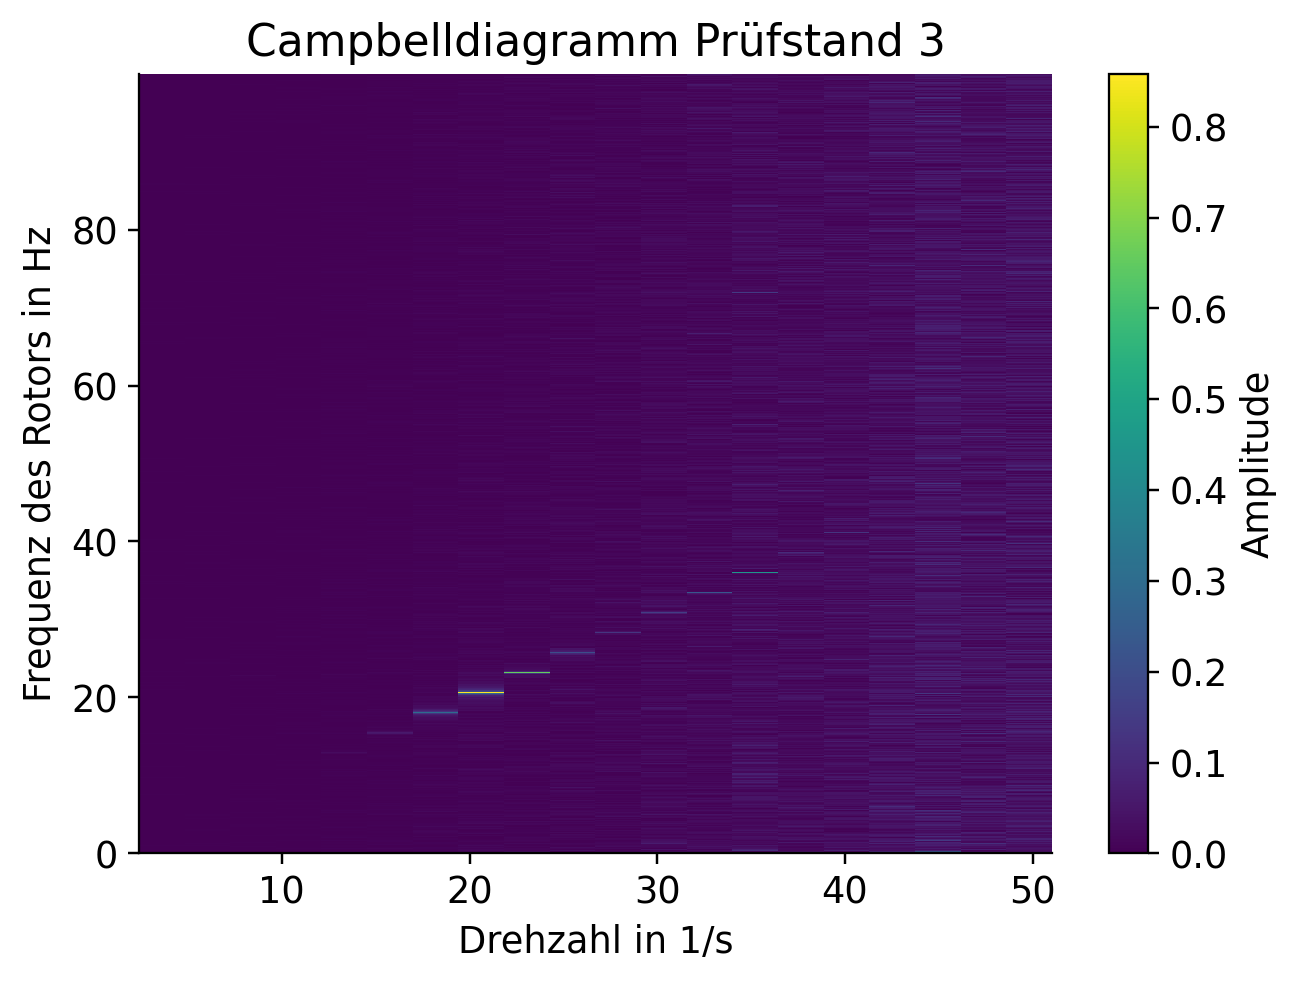

In [7]:
rpm = []
freq = []
for ii in keys:
    rpm.append(data[str(ii)]["rpm"])
    rpm = [int(x) for x in np.array(rpm).flatten().tolist()]
    

for i in range(len(rpm)):
    rpm[i] = rpm[i] / 60 


Zeilen = len(data["0"]["frequenz"])
Spalten = len(rpm)

M = np.zeros((Zeilen,Spalten))
for i in keys:
    M[:,i] = data[str(i)]["amplitude"]


min_rpm = rpm[0]
max_rpm = rpm[-1]
min_freq = data["0"]["frequenz"][0]
max_freq = data["0"]["frequenz"][-1]

plt.imshow(M,aspect="auto",origin = "lower",extent =(min_rpm,max_rpm,min_freq,max_freq),interpolation="none")
plt.title("Campbelldiagramm Prüfstand 3")
plt.xlabel("Drehzahl in 1/s")
plt.ylabel("Frequenz des Rotors in Hz")
colorbar = plt.colorbar()
colorbar.set_label("Amplitude")

## Zweiter Datensatz: Prüfstand 2

#### 1. Einlesen der Mess- und Metadaten

In [8]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
#print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

#### 2. Verarbeitung der Messdaten

In [9]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

f = h5py.File(path_measurement_folder+"/"+filename,"r")

keys = list(range(41))
data = {}
for ii in keys:
    acc_x = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_x"])
    acc_y = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_y"])
    acc_z = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_z"])
    accel = [acc_x,acc_y,acc_z]
    
    timestamp = np.array(f[str(ii)]["RawData"][uuid_acceleration]["timestamp"])
    
    rpm = np.array(f[str(ii)]["RawData"][uuid_motor_rpm]["motor_rpm"])
    
    data.update({str(ii): {"acceleration" : accel, "rpm": rpm, "timestamp": timestamp}})


#print(data)

importlib.reload(m_postprocessing)  # reload functions

for ii in keys:
    x_acc = data[str(ii)]["acceleration"][0]
    y_acc = data[str(ii)]["acceleration"][1]
    z_acc = data[str(ii)]["acceleration"][2]
    
    acc_vector = m_postprocessing.get_vec_accel(x_acc, y_acc, z_acc)
    data[str(ii)]["acceleration"] = acc_vector
    
    time = data[str(ii)]["timestamp"]
    data[str(ii)]["int_data"] = m_postprocessing.interpolation(time, acc_vector, interpolation_points)
#print(data)

for ii in keys:
    acc_int = data[str(ii)]["int_data"]
    time = data[str(ii)]["timestamp"]
    data[str(ii)]["amplitude"], data[str(ii)]["frequenz"] = m_postprocessing.my_fft_scaled(acc_int, time)
    
#print(data)

#### 3. Darstellung mittels Campbell-Diagramm

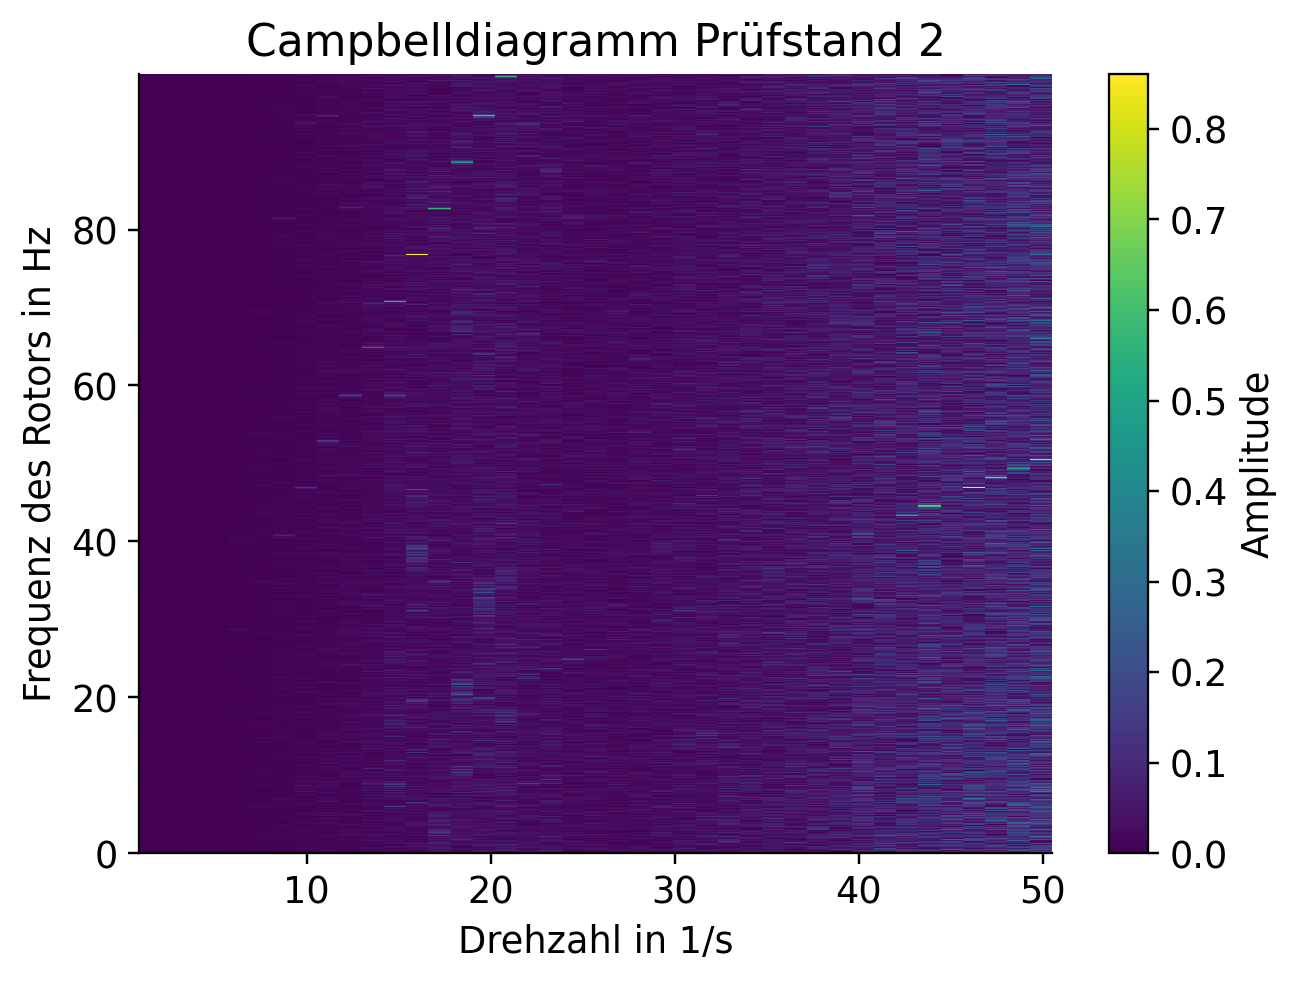

In [10]:
rpm = []
freq = []
for ii in keys:
    rpm.append(data[str(ii)]["rpm"])
    rpm = [int(x) for x in np.array(rpm).flatten().tolist()]
    

for i in range(len(rpm)):
    rpm[i] = rpm[i] / 60 


Zeilen = len(data["0"]["frequenz"])
Spalten = len(rpm)

M = np.zeros((Zeilen,Spalten))
for i in keys:
    M[:,i] = data[str(i)]["amplitude"]


min_rpm = rpm[0]
max_rpm = rpm[-1]
min_freq = data["0"]["frequenz"][0]
max_freq = data["0"]["frequenz"][-1]

plt.imshow(M,aspect="auto",origin = "lower",extent =(min_rpm,max_rpm,min_freq,max_freq),interpolation="none")
plt.title("Campbelldiagramm Prüfstand 2")
plt.xlabel("Drehzahl in 1/s")
plt.ylabel("Frequenz des Rotors in Hz")
colorbar = plt.colorbar()
colorbar.set_label("Amplitude")

## Dritter Datensatz: Prüfstand 4

#### 1. Einlesen der Mess- und Metadaten

In [11]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240109_104244_lavalrotor_01_04"
)  # path to the folder with H5-file and metadata
filename = "data_20240109_104244_lavalrotor_01_04.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
#print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

#### 2. Verarbeitung der Messdaten

In [12]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

f = h5py.File(path_measurement_folder+"/"+filename,"r")

keys = list(range(20))
data = {}
for ii in keys:
    acc_x = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_x"])
    acc_y = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_y"])
    acc_z = np.array(f[str(ii)]["RawData"][uuid_acceleration]["acceleration_z"])
    accel = [acc_x,acc_y,acc_z]
    
    timestamp = np.array(f[str(ii)]["RawData"][uuid_acceleration]["timestamp"])
    
    rpm = np.array(f[str(ii)]["RawData"][uuid_motor_rpm]["motor_rpm"])
    
    data.update({str(ii): {"acceleration" : accel, "rpm": rpm, "timestamp": timestamp}})


#print(data)

importlib.reload(m_postprocessing)  # reload functions

for ii in keys:
    x_acc = data[str(ii)]["acceleration"][0]
    y_acc = data[str(ii)]["acceleration"][1]
    z_acc = data[str(ii)]["acceleration"][2]
    
    acc_vector = m_postprocessing.get_vec_accel(x_acc, y_acc, z_acc)
    data[str(ii)]["acceleration"] = acc_vector
    
    time = data[str(ii)]["timestamp"]
    data[str(ii)]["int_data"] = m_postprocessing.interpolation(time, acc_vector, interpolation_points)
#print(data)

for ii in keys:
    acc_int = data[str(ii)]["int_data"]
    time = data[str(ii)]["timestamp"]
    data[str(ii)]["amplitude"], data[str(ii)]["frequenz"] = m_postprocessing.my_fft_scaled(acc_int, time)
    
#print(data)

#### 3. Darstellung mittels Campbell-Diagramm

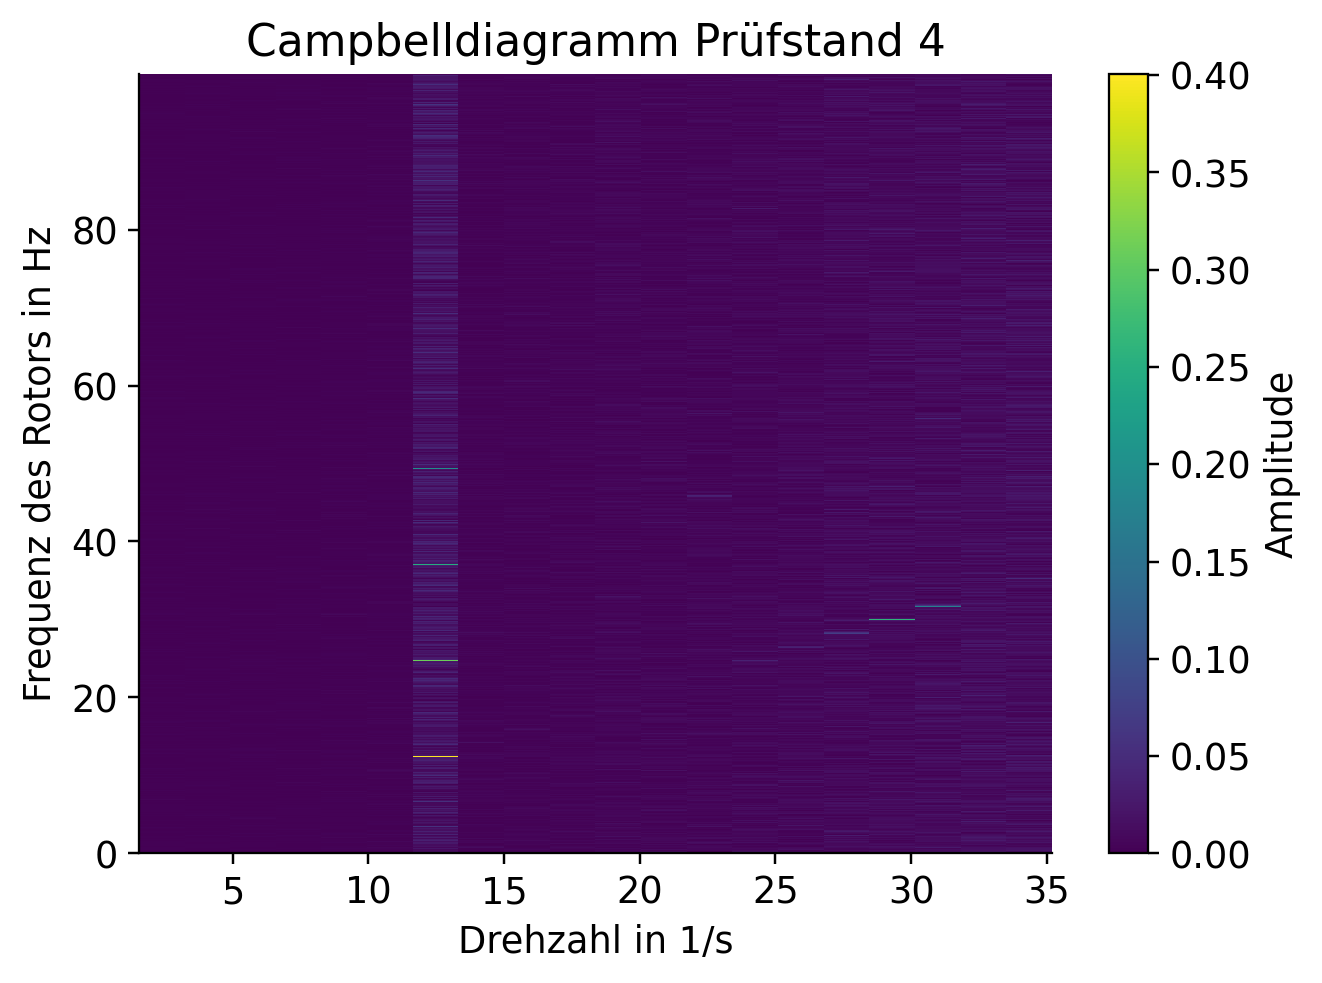

In [13]:
rpm = []
freq = []
for ii in keys:
    rpm.append(data[str(ii)]["rpm"])
    rpm = [int(x) for x in np.array(rpm).flatten().tolist()]
    

for i in range(len(rpm)):
    rpm[i] = rpm[i] / 60 


Zeilen = len(data["0"]["frequenz"])
Spalten = len(rpm)

M = np.zeros((Zeilen,Spalten))
for i in keys:
    M[:,i] = data[str(i)]["amplitude"]


min_rpm = rpm[0]
max_rpm = rpm[-1]
min_freq = data["0"]["frequenz"][0]
max_freq = data["0"]["frequenz"][-1]

plt.imshow(M,aspect="auto",origin = "lower",extent =(min_rpm,max_rpm,min_freq,max_freq),interpolation="none")
plt.title("Campbelldiagramm Prüfstand 4")
plt.xlabel("Drehzahl in 1/s")
plt.ylabel("Frequenz des Rotors in Hz")
colorbar = plt.colorbar()
colorbar.set_label("Amplitude")

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Die abgelesenen kritischen Drehzahlen der Prüfstände:
$$
\begin{align*}
Prüfstand\ 3: & \quad \omega_{31} = 21\ \frac{1}{s} \\
Prüfstand\ 2: & \quad \omega_{21} = 17\ \frac{1}{s} \ , \quad \omega_{22} = 46\ \frac{1}{s} \\
Prüfstand\ 4: & \quad \omega_{41} = 12\ \frac{1}{s} \ , \quad \omega_{42} = 30\ \frac{1}{s} \\
\end{align*}
$$

In jedem Datensatz können kritische Drehzahlen abgelesen werden. Vor der kritischen Drehzahl steigt die Amplitude der Schwingung langsam an. Ebenso sinkt die Amplitude der Schwingung nach der kritischen Drehzahl wieder langsam ab.Somit kann die Forschungsfrage bestätigt werden.

Bei dem Prüfstand 3 und 2 stimmt die Anzahl der kritischen Drehzahlen mit der Anzahl an Scheiben überein. Bei dem Prüfstand 4 jedoch nicht. Dieser hat eine Scheibe aber 2 kritische Drehzahlen, was unerwartet ist. Die obere kritische Drehzahl könnte aus der Eigenfrequenz des Tisches oder aus einem vielfachen der ersten kritischen Drehzahl resultieren.

Durch die Selbstzentrierung sollte bei einer hohen Motordrezahl die Schwingungsamplitude abnehemen. In den Messdaten steigt jedoch in den höheren Frequenzen die Schwigungsamplitude in allen Frequenzen an.

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

Die errechnete kritische Drehzahl der Welle im Püfstand 3 beträgt 18,17 1/s. Die gemessene kritische Drehzahl beträgt 21 1/s. Somit ergibt sich eine Differenz von 3 1/s.

Die Differenz könnte zum einen aus der geringen Anzahl an Messdrehzahlen aber auch durch Dämpfung durch Reibung resultieren.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Das Durchführen des Versuches war interessant und nicht zu kompliziert. Ich hatte jedoch erwartet, dass die Welle in der kritischen Drehzahl stärker schwingt und durch die Selbstzentrierung noch ruhiger dreht. Die Darstellung der Daten im Campbelldiagramm war sehr anspruchsvoll. Durch das Arbeiten mit dem Champbelldiagramm habe ich ein besseres Verständnis über die Schwingungseigenschaften eines System erlangt.